# Example notebook to apply bias adjustment techniques 

In [12]:
__author__ = 'Benjamin Thomas Schwertfeger'
__copyright__ = __author__
__email__ = 'development@b-schwertfeger.de'
__link__ = 'https://b-schwertfeger.de'
__github__ = 'https://github.com/btschwertfeger/Bias-Adjustment-Python';

In [2]:
import numpy as np
import xarray as xr
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

# Define some functions 

In [3]:
historical_time = xr.cftime_range("1971-01-01", "2000-12-31", freq="D", calendar="noleap")
future_time = xr.cftime_range("2001-01-01", "2030-12-31", freq="D", calendar="noleap")

get_hist_temp_for_lat = lambda val: 273.15 - (val * np.cos(2 * np.pi * historical_time.dayofyear / 365) + 2 * np.random.random_sample((historical_time.size,)) + 273.15 + .1 * (historical_time - historical_time[0]).days / 365)
get_rand = lambda: np.random.rand() if np.random.rand() > .5 else  -np.random.rand()

In [4]:
latitudes = np.arange(23,27,1)
some_data = [get_hist_temp_for_lat(val) for val in latitudes]
data = np.array([some_data, np.array(some_data)+1])

# Create dummy data

In [5]:
obsh = xr.DataArray(
    data,
    dims=('lon', 'lat', 'time'),
    coords={'time': historical_time, 'lat': latitudes, 'lon': [0,1]},
    attrs={'units': '°C'},
).transpose('time','lat','lon')#.to_netcdf('obs.nc')

simh = xr.DataArray(
    data-2,
    dims=('lon', 'lat', 'time'),
    coords={'time': historical_time, 'lat': latitudes, 'lon': [0,1]},
    attrs={'units': '°C'},
).transpose('time','lat','lon')#.to_netcdf('contr.nc')

simp = xr.DataArray(
    data-1,
    dims=('lon', 'lat', 'time'),
    coords={'time': future_time, 'lat': latitudes, 'lon': [0,1]},
    attrs={'units': '°C'},
).transpose('time','lat','lon')#.to_netcdf('scen.nc')

# Plot created toy data

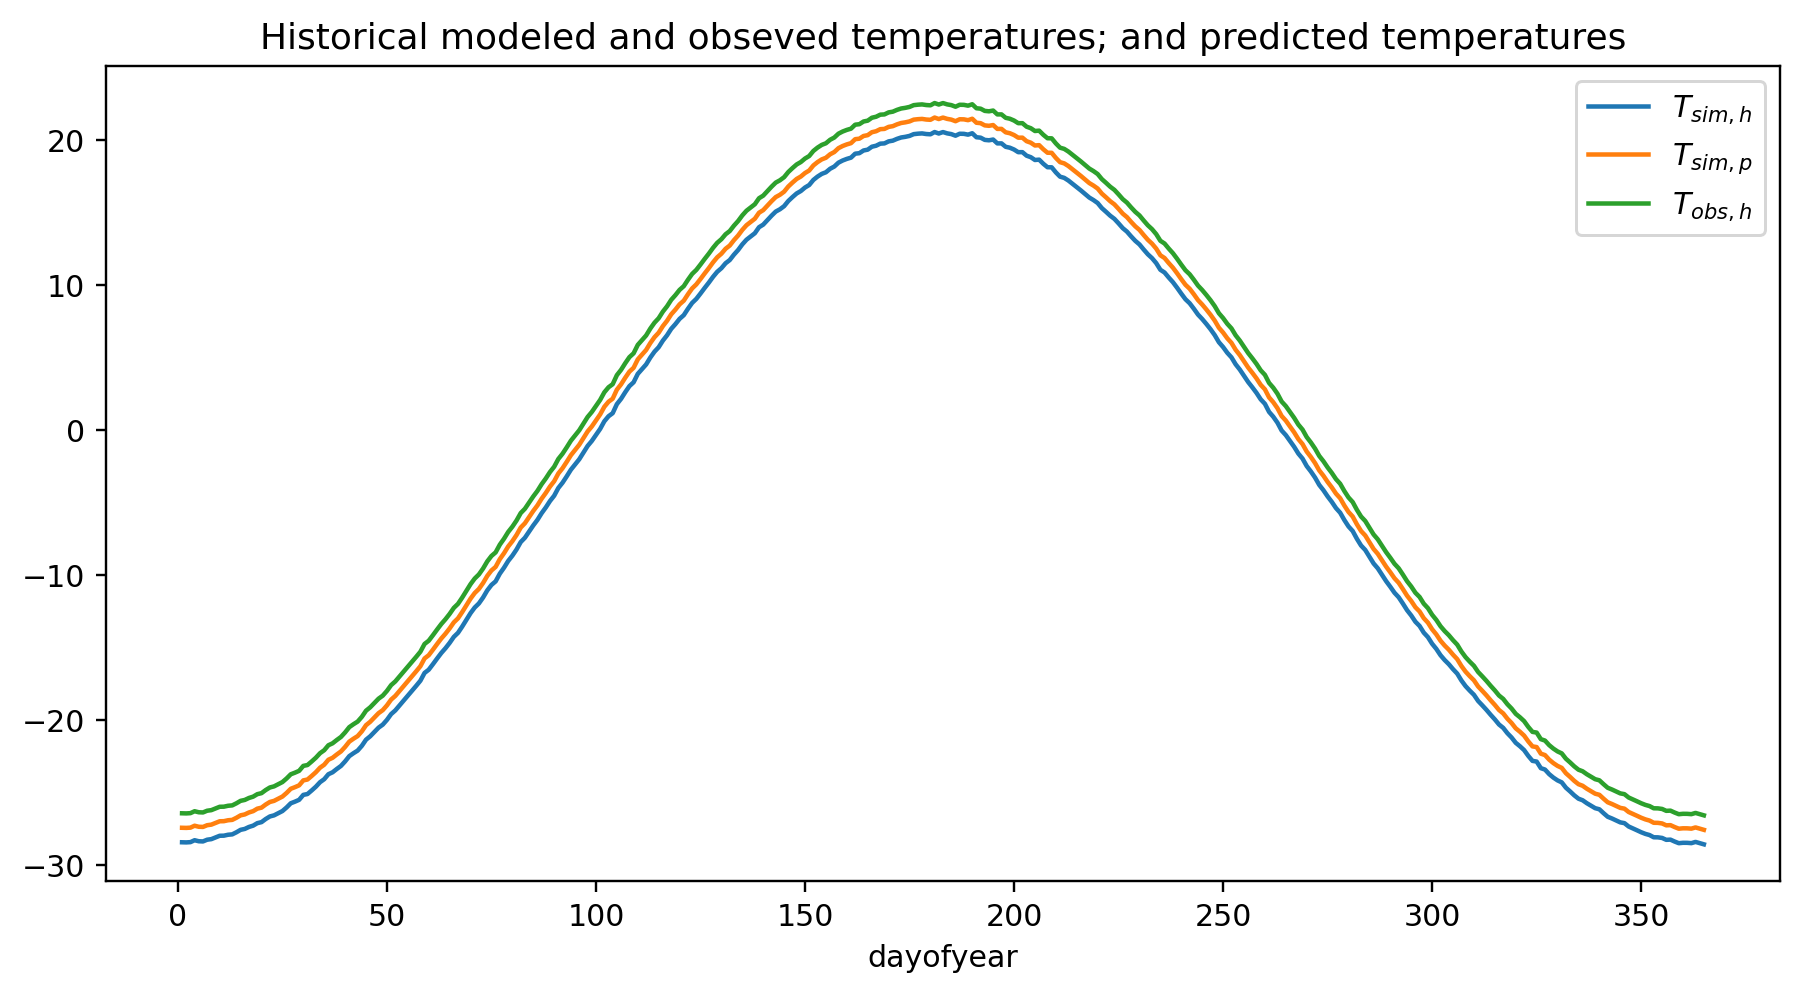

In [6]:
plt.figure(figsize=(10,5),dpi=216)
simh.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,h}$')
simp.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,p}$')
obsh.groupby('time.dayofyear').mean(...).plot(label='$T_{obs,h}$')
plt.title('Historical modeled and obseved temperatures; and predicted temperatures')
plt.legend()

* Modeled historical temperatures are to warm in comparison to the observed temperatures.

# Import adjustment stuff

In [7]:
from CMethods import CMethods
cm = CMethods()

## Apply QDM adjustment

In [8]:
qdm_result = cm.adjust_2d(
    method = 'quantile_delta_mapping',
    obs = obsh,
    simh = simh,
    simp = simp,
    n_quaniles = 100,
    kind = '+',
)

100%|██████████| 4/4 [00:00<00:00, 20.51it/s]


## Visualize QDM result

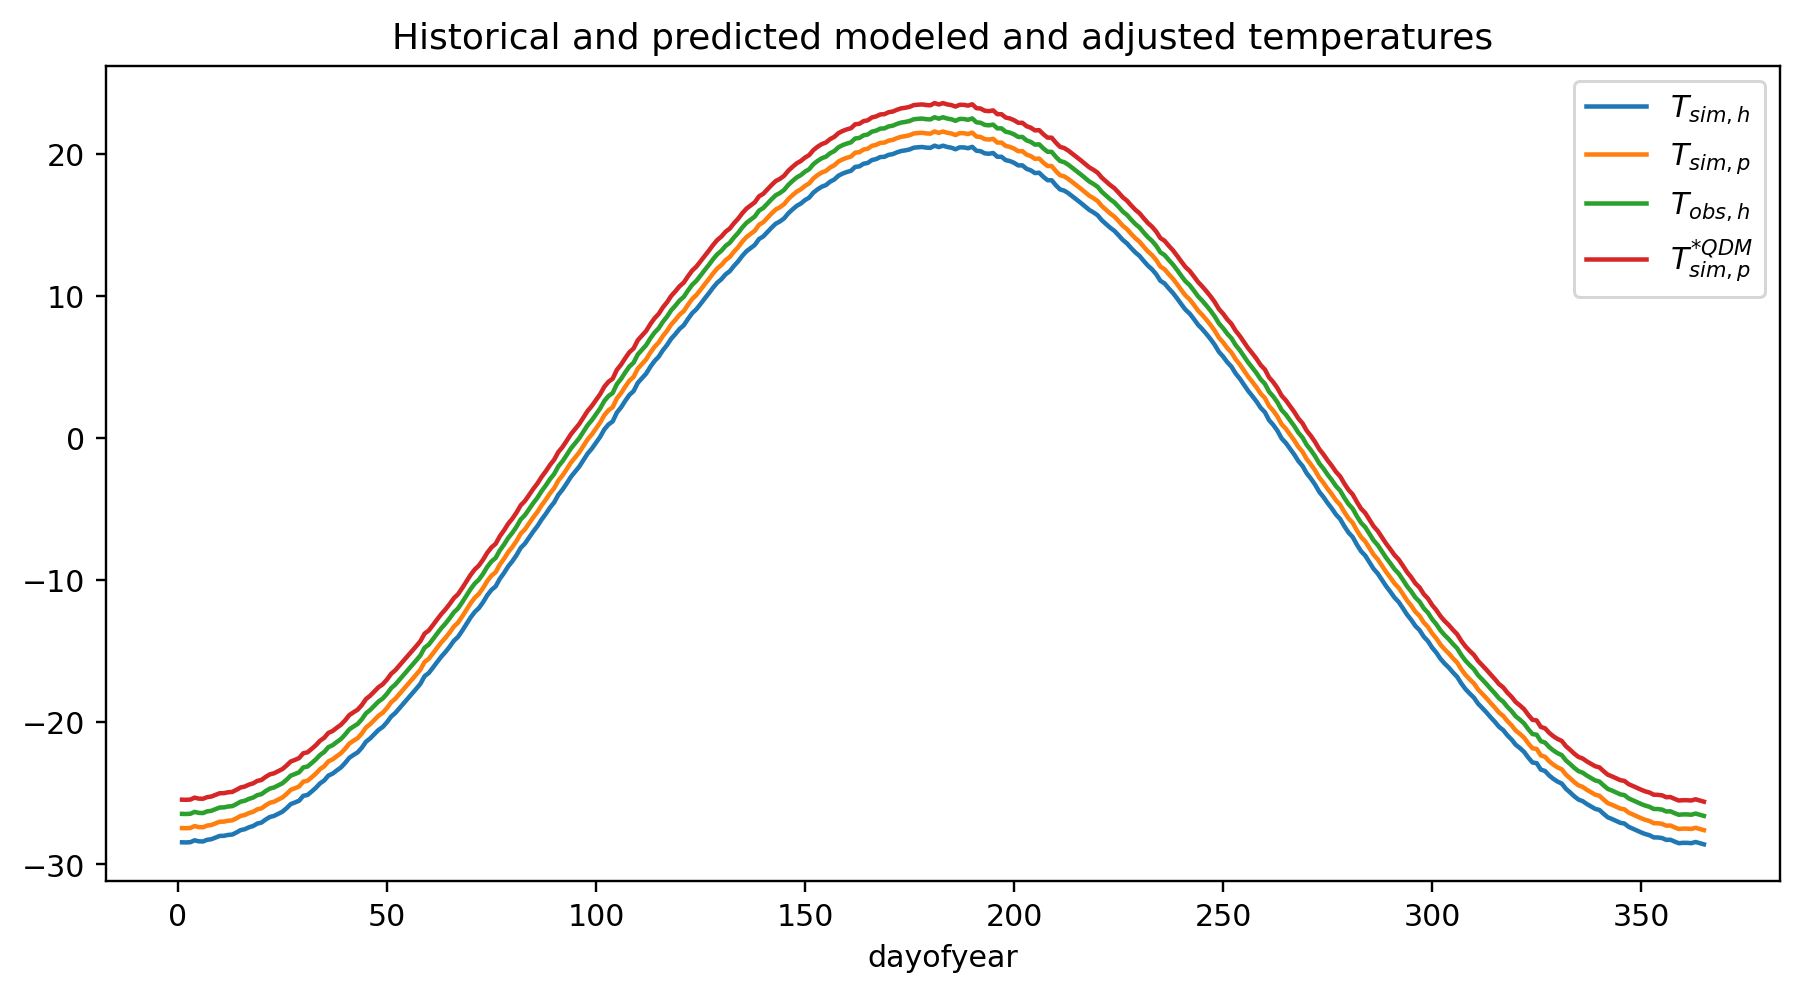

In [9]:
plt.figure(figsize=(10,5),dpi=216)
simh.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,h}$')
simp.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,p}$')
obsh.groupby('time.dayofyear').mean(...).plot(label='$T_{obs,h}$')
qdm_result.groupby('time.dayofyear').mean(...).plot(label='$T^{*QDM}_{sim,p}$')
plt.title('Historical and predicted modeled and adjusted temperatures')
plt.legend()

* After the adjustment, the predicted temperatures got warmer ($T^{*QDM}_{sim,p} > T_{sim,p}$)

In [10]:
ls_result = cm.adjust_2d( method = 'linear_scaling', obs = obsh, simh = simh, simp = simp, kind = '+' )
vs_result = cm.adjust_2d( method = 'variance_scaling', obs = obsh, simh = simh, simp = simp, kind = '+' )
dm_result = cm.adjust_2d( method = 'delta_method', obs = obsh, simh = simh, simp = simp, kind = '+' )

100%|██████████| 4/4 [00:00<00:00, 27.48it/s]


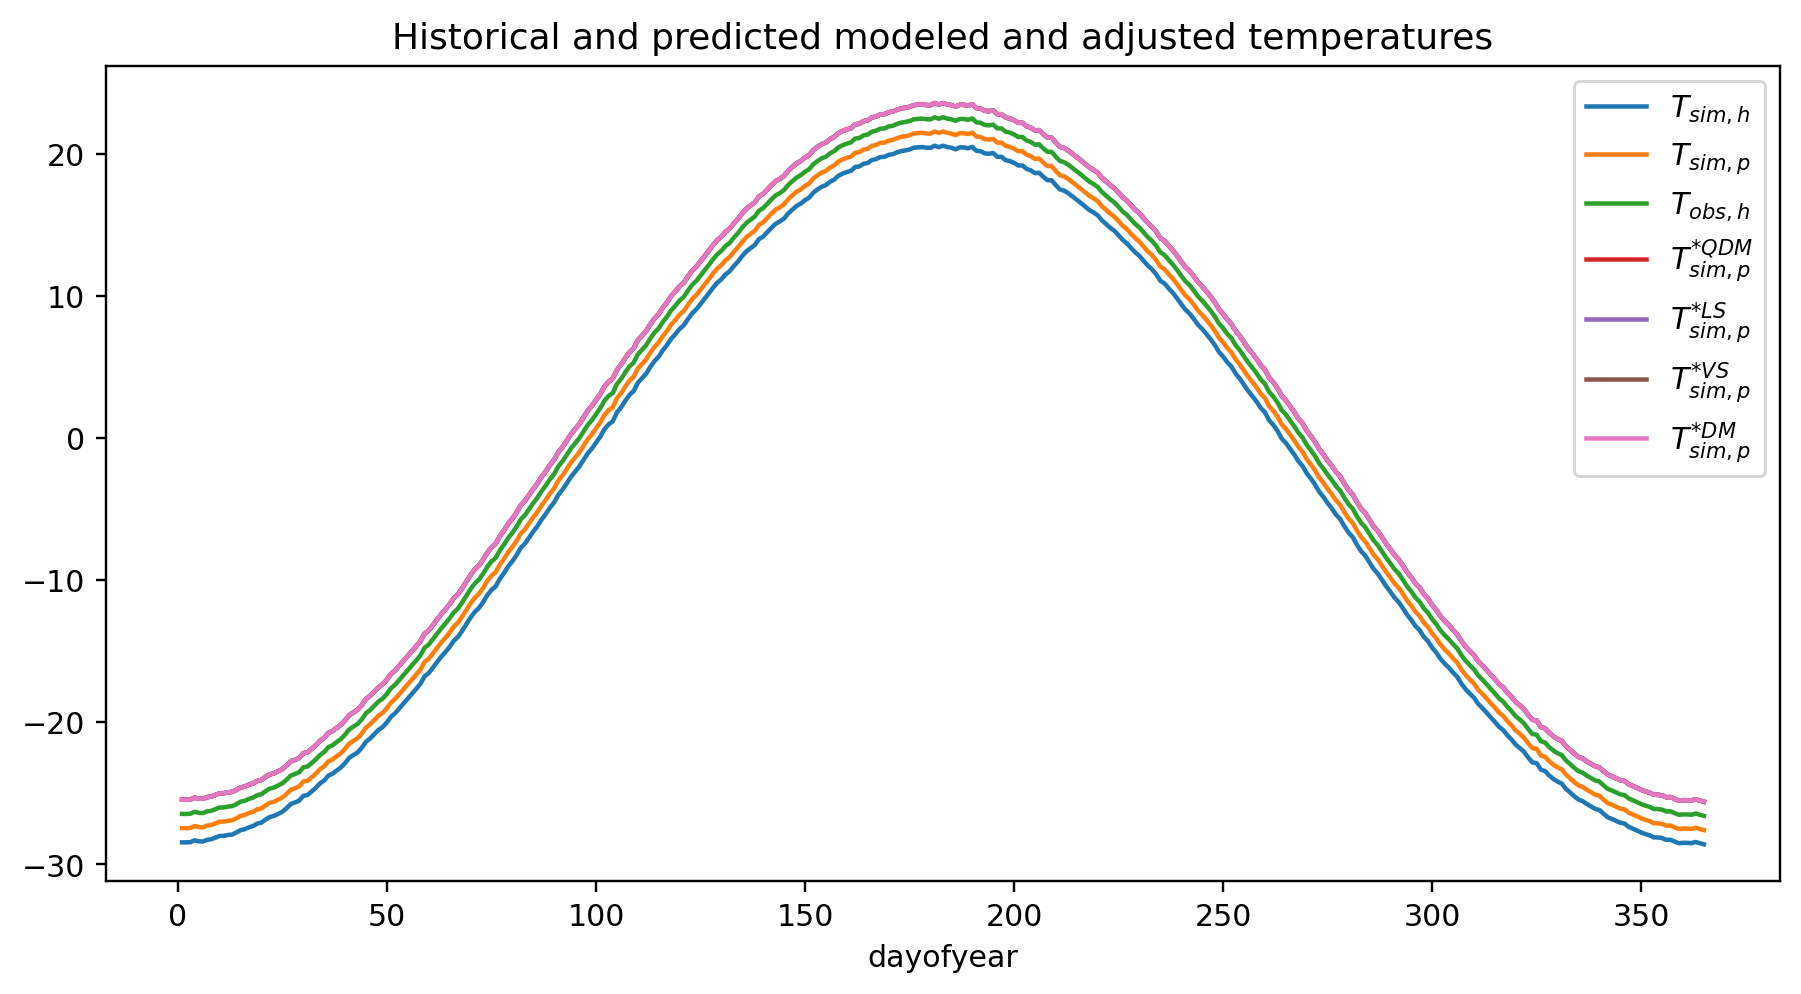

In [11]:
plt.figure(figsize=(10,5),dpi=216)
simh.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,h}$')
simp.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,p}$')
obsh.groupby('time.dayofyear').mean(...).plot(label='$T_{obs,h}$')
qdm_result.groupby('time.dayofyear').mean(...).plot(label='$T^{*QDM}_{sim,p}$')
ls_result.groupby('time.dayofyear').mean(...).plot(label='$T^{*LS}_{sim,p}$')
vs_result.groupby('time.dayofyear').mean(...).plot(label='$T^{*VS}_{sim,p}$')
dm_result.groupby('time.dayofyear').mean(...).plot(label='$T^{*DM}_{sim,p}$')
plt.title('Historical and predicted modeled and adjusted temperatures')
plt.legend()

* Because of dummy data all adjusted datasets seem to have the same result